In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer

In [2]:
def create_data(seed, n, dataset_size=100):
    np.random.seed(seed)
    # sample data from Gaussian
    data0_raw = np.random.normal(2**(n-1), scale=2, size=dataset_size)
    bins = np.arange(2**n + 1).astype(np.float64)
    bins[-1] = np.inf
    counts0, _ = np.histogram(data0_raw, bins=bins)
    data0 = np.clip(np.floor(data0_raw), 0, 2**n - 1)

    data1_raw = np.random.normal(2**(n-2), scale=1, size=dataset_size)
    counts1, _ = np.histogram(data1_raw, bins=bins)
    data1 = np.clip(np.floor(data1_raw), 0, 2**n - 1)
    
    return data0, data1

In [3]:
N = 120
n = 4

data0, data1 = create_data(0, n, dataset_size=N)

In [4]:
data = data1

Classical dataset probabilities


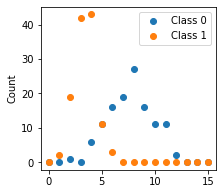

In [5]:

bins = np.arange(2**n + 1).astype(np.float64)
bins[-1] = np.inf
probs0, _ = np.histogram(data0, bins=bins)
probs1, _ = np.histogram(data1, bins=bins)

print('Classical dataset probabilities')
plt.figure(figsize=(3.2, 2.8))
plt.scatter(bins[:-1], probs0, label='Class 0')
plt.scatter(bins[:-1], probs1, label='Class 1')
plt.legend()
plt.ylabel('Count')
plt.tight_layout()
plt.show()
     

In [6]:
def ansatz(params, qubits):
    j = 0
    center = 1
    for i in range(1, n):
        if i == center:
            qml.RY(np.pi/2, wires=qubits[i])
            qml.PauliX(wires=qubits[i])
        else:
            qml.RX(2*params[j],wires=qubits[i])
            j += 1
    for i in range(1, n):
        if i != center:
            qml.RY(np.pi/2, wires=qubits[i])
            qml.PauliX(wires=qubits[i])
            qml.CZ(wires=[qubits[center], qubits[i]])
            qml.RY(np.pi/2,wires=qubits[i])
            qml.PauliZ(wires=qubits[i])

In [7]:
dev = qml.device('lightning.qubit', wires=9)
@qml.qnode(dev)
def plot_ansatz(params, qubits):
    ansatz(params, qubits)
    return qml.probs()

/tmp/ipykernel_1465990/3972935481.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


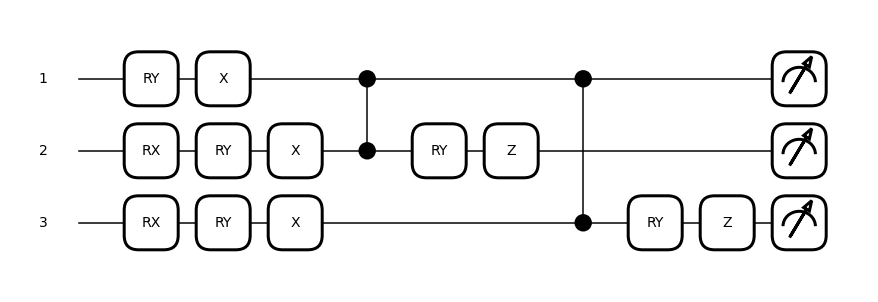

In [8]:
fig, ax = qml.draw_mpl(plot_ansatz)(np.ones(20),[0,1,2,3])
fig.show()

In [9]:
def num_circuit(num, wires):
    bin_str = format(int(num), '#06b')[2:]
    for i, c in enumerate(bin_str):
        if c == '1':
            qml.PauliX(wires=i+wires[0])
    

In [22]:
@qml.qnode(dev)
def training_circ(data, paramsg, paramsd):
    # top 4 qbits real data
    num_circuit(data, [1,2,3,4])
    # bottom 4 qbits gen ansatz
    ansatz(paramsg, [5,6,7,8])
    # parametrized swap test
    qml.Hadamard(wires=0)
    for i in range(1,9): 
        para = paramsd[(i-1)*3:(i)*3]
        #qml.Rot(para[0],para[1],para[2],wires=i)
        qml.RZ(para[0],wires=i)
    #for i in range(5,9):
    #    para = paramsd[(i-5)*3:(i-4)*3]
    #    #qml.Rot(para[0],para[1],para[2],wires=i)
    #    qml.RZ(para[0],wires=i)
    qml.CSWAP(wires=[0,1,5])
    qml.CSWAP(wires=[0,2,6])
    qml.CSWAP(wires=[0,3,7])
    qml.CSWAP(wires=[0,4,8])
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))

In [11]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]
        
def cost_batch_old(paramsg, paramsd, batch):
    loss = 0.0
    for i in batch:
        f = training_circ(i, paramsg, paramsd)
        loss = loss + (1 - f)
    return loss / len(batch)

def cost_batch(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
        f = training_circ(i, paramsg, paramsd) + reg
        f = np.log(f)
        #loss = loss + (1 - f)
        loss += -f
    return loss / len(batch)

In [12]:
paramsg = np.random.uniform(0,np.pi, size=3, requires_grad=True)
paramsd = np.random.uniform(0,np.pi, size=8*3, requires_grad=True)

In [46]:
epochs = 200
batch_size=16
learning_rate=0.005

In [47]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
optd = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

In [48]:
print("initial paramsg:", paramsg)
print("initial paramsd:", paramsd)

paramsg_before = paramsg.copy()
paramsd_before = paramsd.copy()

losshist = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        if it % 2 == 0:
            cost_fn = lambda p: -1*cost_batch(paramsg, p, Xbatch)
            paramsd = optd.step(cost_fn, paramsd)
        if it % 2 == 1:
            cost_fn = lambda p: cost_batch(p, paramsd, Xbatch)
            paramsg = optg.step(cost_fn, paramsg)
        print(j, end="\r")
        #if j % 20 == 0:
        #    loss = cost_batch(params,Xbatch)
        #    print(f"Step: {j} | Loss: {loss:.3} |")
    
    loss = cost_batch(paramsg, paramsd, data)
    
    losshist += [loss]
    
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

print("final paramsg:", paramsg)
print("final paramsd:", paramsd)

initial paramsg: [0.19049552 0.52391013 0.17396356]
initial paramsd: [0.94750006 0.82346845 1.43300785 2.14659162 2.18537179 0.89070073
 1.19357573 0.56910253 2.47728879 0.1785935  2.18968141 2.44634374
 2.44229788 0.81500002 1.17436861 1.84599869 0.85709528 1.16506843
 0.61906428 1.44467987 0.14015368 2.51263287 0.24176581 1.62996869]
____
Epoch: 0 | Loss: 1.43 | 
____
____
Epoch: 1 | Loss: 1.43 | 
____
____
Epoch: 2 | Loss: 1.43 | 
____
____
Epoch: 3 | Loss: 1.43 | 
____
____
Epoch: 4 | Loss: 1.43 | 
____
____
Epoch: 5 | Loss: 1.43 | 
____
____
Epoch: 6 | Loss: 1.43 | 
____
____
Epoch: 7 | Loss: 1.43 | 
____
____
Epoch: 8 | Loss: 1.43 | 
____
____
Epoch: 9 | Loss: 1.43 | 
____
____
Epoch: 10 | Loss: 1.43 | 
____
____
Epoch: 11 | Loss: 1.43 | 
____
____
Epoch: 12 | Loss: 1.43 | 
____
____
Epoch: 13 | Loss: 1.43 | 
____
____
Epoch: 14 | Loss: 1.43 | 
____
____
Epoch: 15 | Loss: 1.43 | 
____
____
Epoch: 16 | Loss: 1.43 | 
____
____
Epoch: 17 | Loss: 1.43 | 
____
____
Epoch: 18 | Loss: 1

Text(0, 0.5, 'loss')

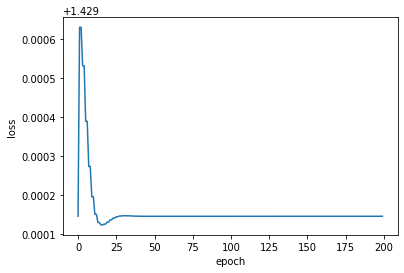

In [49]:
plt.plot(losshist)
plt.xlabel("epoch")
plt.ylabel("loss")

In [50]:
sample_dev = qml.device('lightning.qubit', wires=4, shots = N)
@qml.qnode(sample_dev)
def sample_test():
    ansatz(paramsg, [0,1,2,3])
    return qml.sample()

In [51]:
testresult = [int(''.join(str(i) for i in a), 2) for a in sample_test()]

In [52]:
valuestest, countstest = np.unique(testresult, return_counts=True)
values, counts = np.unique(data, return_counts=True)

In [53]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in valuestest]
zeros = np.zeros(len(zerovals))
valuestest = np.append(valuestest, zerovals)
countstest = np.append(countstest, zeros)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

(0.0, 16.0)

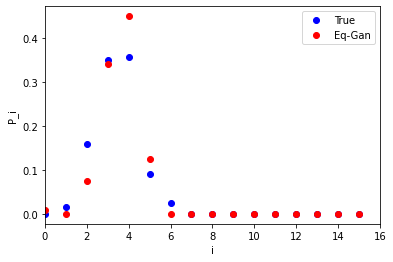

In [54]:
plt.plot(values,counts/N, 'b.', markersize=12, label="True")
plt.plot(valuestest,countstest/N, 'r.', markersize=12, label="Eq-Gan")
plt.ylabel('P_i')
plt.xlabel('i')
plt.legend()
plt.xlim(0,16)